In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
plt.style.use("seaborn")
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier,to_graphviz, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score,ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,cross_validate, GridSearchCV
from sklearn.decomposition import PCA

In [ ]:
adult = (pd.read_csv("/content/drive/MyDrive/adultke.csv")).drop("Unnamed: 0",axis=1)

In [ ]:
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
45218,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
45219,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
45220,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [ ]:
adultWithdummy = pd.get_dummies(adult,drop_first=True)

In [ ]:
X = pd.get_dummies(adult.drop("target",axis=1),drop_first=True,dtype=float)
y = pd.get_dummies(adult.target,drop_first=True,dtype=float)+1
y[y == 2] = 0
y = y.to_numpy().ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [ ]:
col_names2 = ["Model","Accuracy","Roc - Auc","F1","Recall","Precision"]
scores = pd.DataFrame(columns=col_names2)
modeller = [XGBClassifier(),RandomForestClassifier(),DecisionTreeClassifier(),LogisticRegression()]
modeller2 = [KNeighborsClassifier(),SVC(),MLPClassifier(),GaussianNB()]
modelnames = ["XGBoost","Random Forest","Decision Tree","Logistic Regression"]
modelnames2 = ["K-NN","SVC","Neural Networks","Naive Bayes"]
pd.DataFrame({})
def modeldensec(modeller):
  global scores
  skb = SelectKBest(chi2).fit(X_train,y_train)
  x_trainchi = skb.transform(X_train)
  for i,j in zip(modeller,range(len(modelnames))):
    clf = SelectFromModel(i).fit(X_train,y_train)
    xtrain = clf.transform(X_train)
    testscores = cross_validate(i,xtrain,y_train,scoring=["accuracy","roc_auc","f1","recall","precision"],cv=5,n_jobs=-1)
    auc = testscores["test_roc_auc"].mean()
    accu = testscores["test_accuracy"].mean()
    f1 = testscores["test_f1"].mean()
    reca = testscores["test_recall"].mean()
    pre = testscores["test_precision"].mean()
    scores = scores.append({"Model":modelnames[j],"Accuracy":accu,"Roc - Auc":auc,"F1":f1,"Recall":reca,"Precision":pre},ignore_index=True)
  
  for z,v in zip(modeller2,range(len(modelnames2))):
    testscores = cross_validate(z,x_trainchi,y_train,scoring=["accuracy","roc_auc","f1","recall","precision"],cv=5,n_jobs=-1)
    auc = testscores["test_roc_auc"].mean()
    accu = testscores["test_accuracy"].mean()
    f1 = testscores["test_f1"].mean()
    reca = testscores["test_recall"].mean()
    pre = testscores["test_precision"].mean()
    scores = scores.append({"Model":modelnames2[v],"Accuracy":accu,"Roc - Auc":auc,"F1":f1,"Recall":reca,"Precision":pre},ignore_index=True)
  return scores


In [ ]:
modeldensec(modeller)

,Model,Accuracy,Roc - Auc,F1,Recall,Precision
0,XGBoost,0.861155,0.918716,0.911328,0.948550,0.876925
1,Random Forest,0.843879,0.896131,0.898238,0.916063,0.881107
2,Decision Tree,0.805844,0.742537,0.870557,0.868179,0.873006
3,Logistic Regression,0.823368,0.860599,0.886084,0.913270,0.860514
4,K-NN,0.769743,0.669785,0.856651,0.914703,0.805534
5,SVC,0.789037,0.628909,0.876869,0.998677,0.781546
6,Neural Networks,0.694862,0.694952,0.761915,0.761339,0.858733
7,Naive Bayes,0.788374,0.823413,0.870712,0.947411,0.805505


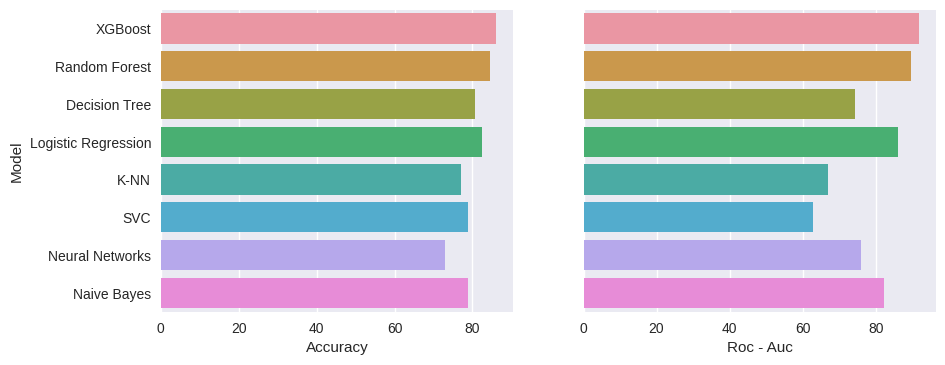

In [ ]:
plt.style.use("seaborn")
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=100)
p1 = sns.barplot(x=scores.Accuracy*100,y=scores.Model,ax=ax[0]);
p2 = sns.barplot(x=scores["Roc - Auc"]*100,y=scores.Model,ax=ax[1]).set(yticklabels=[],ylabel="");

In [ ]:
# Bakıldığında modelimiz için Doğruluk ve Auc skoru olarak en iyi sonuçlar XGBoost algoritmasında elde edilmiştir.

In [ ]:
#x_train = (SelectFromModel(XGBClassifier()).fit(X_train,y_train)).transform(X_train)
#x_test = (SelectFromModel(XGBClassifier()).fit(X_train,y_train)).transform(X_test)
param_grid = {"max_depth":np.arange(7,20,2),
              "n_estimators":np.arange(100,301,50),
              "colsample_bytree":[0.01,0.05,0.1,0.5],
              "subsample":[0.05,0.1,0.5,1],
              "learning_rate":[0.05,0.1,0.3,0.5]}
clf = GridSearchCV(XGBClassifier(tree_method="gpu_hist"),param_grid=param_grid,n_jobs=-1,verbose=2)
t1 = time.time()
clf.fit(x_train,y_train)
t2 = time.time()

Fitting 5 folds for each of 2240 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.4s


In [ ]:
print(clf.best_params_)
clf.best_estimator_

{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 250, 'subsample': 1}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
import time
clf = SelectFromModel(XGBClassifier()).fit(X_train,y_train)
x_train = pd.DataFrame((SelectFromModel(XGBClassifier()).fit(X_train,y_train)).transform(X))
x_train.columns = fmap
x_train.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
x_test = (SelectFromModel(XGBClassifier()).fit(X_train,y_train)).transform(X_test)
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
            learning_rate=0.05, max_delta_step=0, max_depth=7,
            min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
            nthread=None, objective='binary:logistic', random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
            silent=None, subsample=1, verbosity=1,tree_method="gpu_hist").fit(x_train,y_train)
scores = cross_validate(model,x_train,y_train,scoring=["accuracy","roc_auc","recall","precision","f1"],cv=5)

In [ ]:
tuned_scores = pd.DataFrame(columns=["Score Type","Scores"])
tuned_scores["Score Type"] = np.array(["Accuracy","Roc - Auc","Recall","Precision","F1 Score"])
tuned_scores["Scores"] = np.array([scores["test_accuracy"].mean(),scores["test_roc_auc"].mean(),scores["test_recall"].mean(),scores["test_precision"].mean(),scores["test_f1"].mean(),])

In [ ]:
tuned_scores

,Score Type,Scores
0,Accuracy,0.868950
1,Roc - Auc,0.927296
2,Recall,0.942192
3,Precision,0.890030
4,F1 Score,0.915367


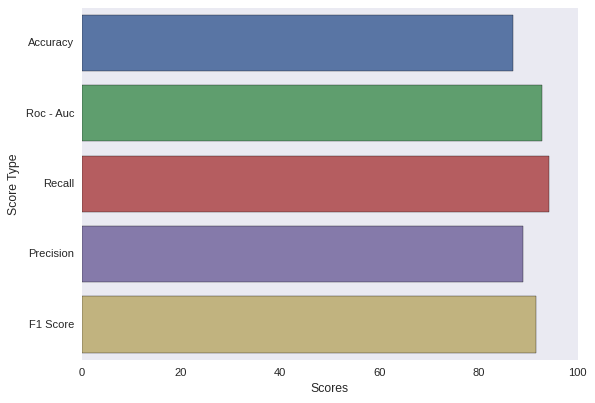

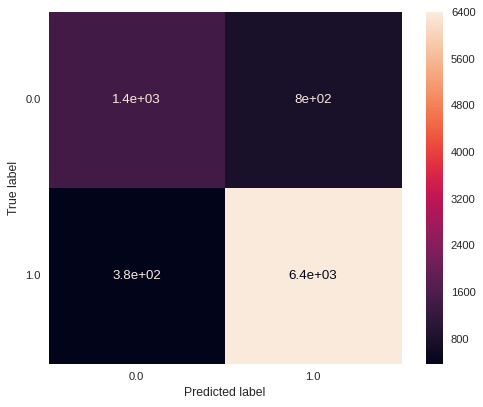

In [ ]:
plt.style.use("seaborn-dark")
sns.barplot(x=tuned_scores.Scores*100,y=tuned_scores["Score Type"]);
plot_confusion_matrix(model,x_test,y_test,cmap="rocket")
